In [1]:
import argparse
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F

from torchvision import datasets, transforms, utils

from scheduler import CycleScheduler

# Data

In [2]:
class vid_faces(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, transform=None):

        self.filenames = glob.glob('/home/jarrod/dev/vq-vae-2-pytorch/256_train_data/*vid*.npy')
#         self.img_transform = transforms.Compose([
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
          
        img = torch.Tensor(np.load(self.filenames[idx]))
        aud = torch.Tensor(np.load(self.filenames[idx].split('_vid_')[0] + '_aud_' + self.filenames[idx].split('_vid_')[1]))
        
        fn = self.filenames[idx].split('_')
        fn = fn[0] + '_' + fn[1] + '_' + fn[2] + '_' + fn[3] + '_0_id.npy'
        
        id_img = torch.Tensor(np.load(fn))
        
        img = img.permute(2,0,1)
        id_img = id_img.permute(2,0,1)
        
        img = ((img / 255.0) * 2) - 1.0
        id_img = ((id_img / 255.0) * 2) - 1.0
        
#         img = self.img_transform(img)
#         id_img = self.img_transform(id_img)
        
        sample = {'id': id_img, 'image': img, 'audio': aud, 'fname':self.filenames[idx]}

        return sample

In [3]:
# grab the names of the pre-processed video files

# build datasets
dataset = vid_faces()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16)

# Model

In [4]:
class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(n_embed))
        self.register_buffer('embed_avg', embed.clone())

    def forward(self, x):
        flatten = x.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*x.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(
                1 - self.decay, embed_onehot.sum(0)
            )
            embed_sum = flatten.transpose(0, 1) @ embed_onehot
            self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - x).pow(2).mean()
        quantize = x + (quantize - x).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, x):
        out = self.conv(x)
        out += x

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()
        
        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        
        
        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(channel // 2, out_channel, 4, stride=2, padding=1),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=16,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()
        
        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        
        self.dec_t = Decoder(embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        
        self.upsample_t = nn.ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)
        
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, x):
        
        quant_t, quant_b, diff, _, _ = self.encode(x)
         
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, x):
        
        enc_b = self.enc_b(x)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
           
        upsample_t = self.upsample_t(quant_t)
        
        quant = torch.cat([upsample_t, quant_b], 1)
        
        dec = self.dec(quant)

        return dec

    # not used
    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

# Train

In [5]:
device = 'cuda'

latent_loss_weight = 0.25

EPOCHS = 30
LR = 1e-3

mse_sum = 0
mse_n = 0

# model = nn.DataParallel(VQVAE()).to(device)
model = VQVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
criterion2 = nn.MSELoss()

scheduler = None

In [15]:
for i, batch in enumerate(dataloader):

        model.zero_grad()

#         if batch['image'].shape[0] != 128:
#             continue

        img = batch['image'].to(device)
        aud = batch['audio'].view(128,1,10000).to(device)
        id_img = batch['id'].to(device)


        out, latent_loss = model(id_img)
        
        break

RuntimeError: shape '[128, 1, 10000]' is invalid for input of size 640000

In [13]:
batch['id'].min()

tensor(-1.)

In [13]:
test = batch['image'].permute(0,2,3,1).cpu().detach().numpy()

In [14]:
test_out = out.permute(0,2,3,1).cpu().detach().numpy()

In [15]:
np.min(test), np.max(test), np.min(test_out), np.max(test_out)

(-1.0, 1.0, -0.2999509, 0.45511606)

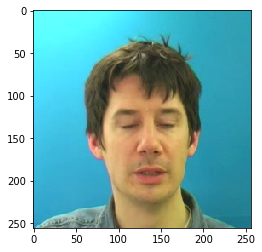

In [14]:
plt.imshow(test[0])

face loss:  0 MSE:  0.2300502061843872 latent loss:  0.0328352265059948 avg MSE:  0.2343263187829186 epoch:  0 image:  50


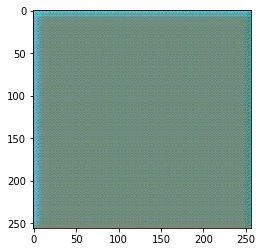

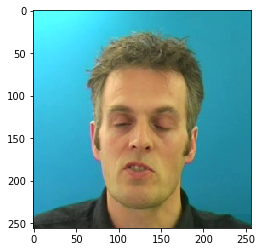

face loss:  0 MSE:  0.21674780547618866 latent loss:  0.053264692425727844 avg MSE:  0.2322717664560469 epoch:  0 image:  100


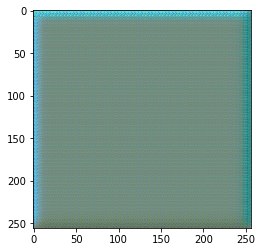

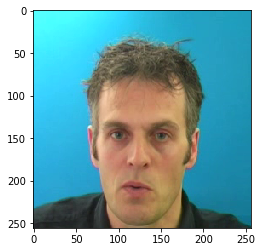

face loss:  0 MSE:  0.19453410804271698 latent loss:  0.4645921587944031 avg MSE:  0.22581164982934662 epoch:  0 image:  150


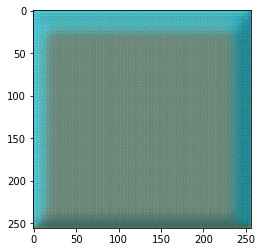

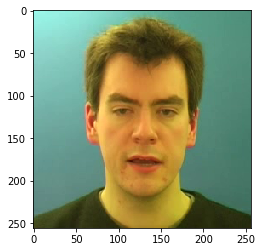

face loss:  0 MSE:  0.20705263316631317 latent loss:  0.02396119013428688 avg MSE:  0.22006065580085735 epoch:  0 image:  200


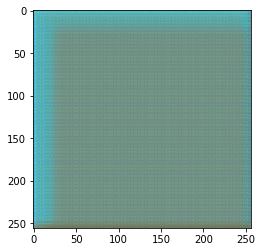

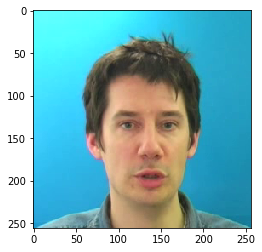

face loss:  0 MSE:  0.2127777636051178 latent loss:  0.029830433428287506 avg MSE:  0.21829118903177194 epoch:  0 image:  250


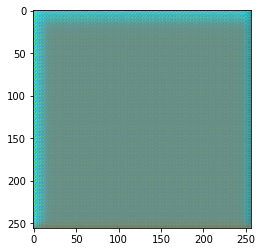

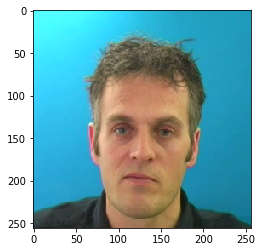

face loss:  0 MSE:  0.17982536554336548 latent loss:  0.17652514576911926 avg MSE:  0.2143333854766383 epoch:  0 image:  300


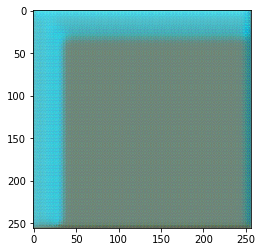

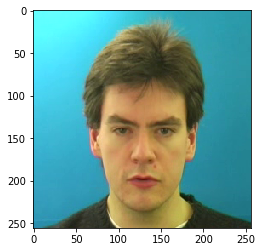

face loss:  0 MSE:  0.2138499915599823 latent loss:  0.0437680184841156 avg MSE:  0.21032380743583723 epoch:  0 image:  350


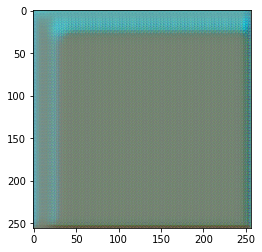

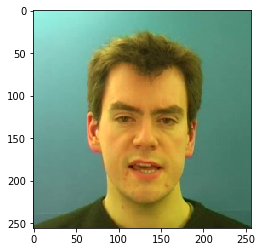

face loss:  0 MSE:  0.11822133511304855 latent loss:  0.10603117942810059 avg MSE:  0.20443973915089395 epoch:  0 image:  400


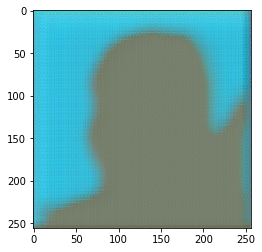

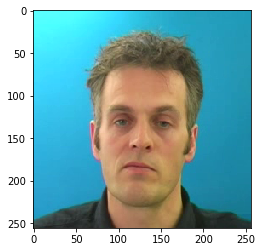

face loss:  0 MSE:  0.19303888082504272 latent loss:  0.056571975350379944 avg MSE:  0.20228367957994836 epoch:  0 image:  450


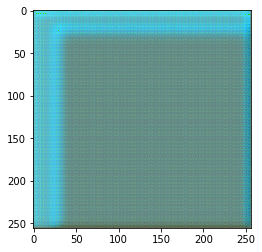

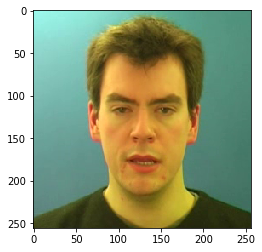

face loss:  0 MSE:  0.14453493058681488 latent loss:  0.03378309682011604 avg MSE:  0.19971352946496534 epoch:  0 image:  500


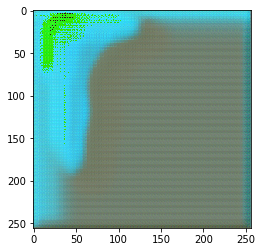

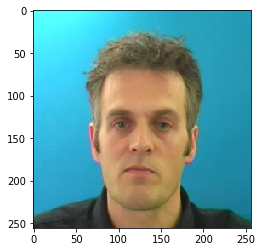

face loss:  0 MSE:  0.08682332932949066 latent loss:  0.08798738569021225 avg MSE:  0.19039735905217606 epoch:  0 image:  550


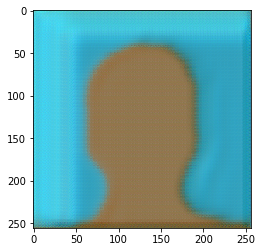

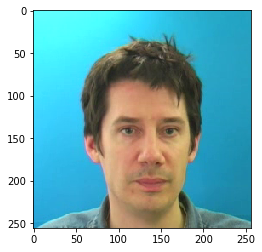

face loss:  0 MSE:  0.08944225311279297 latent loss:  0.20529843866825104 avg MSE:  0.18261902401233077 epoch:  0 image:  600


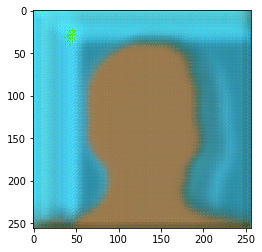

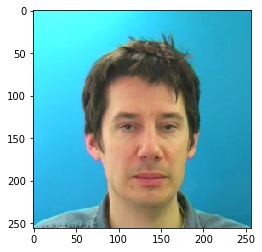

face loss:  0 MSE:  0.08816753327846527 latent loss:  0.05610368400812149 avg MSE:  0.17745780731950486 epoch:  0 image:  650


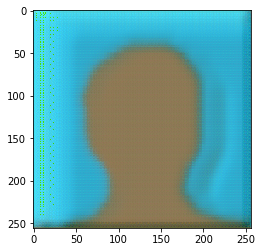

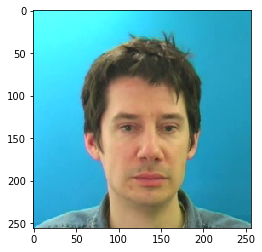

face loss:  0 MSE:  0.20726090669631958 latent loss:  0.08581510186195374 avg MSE:  0.17205293442570363 epoch:  0 image:  700


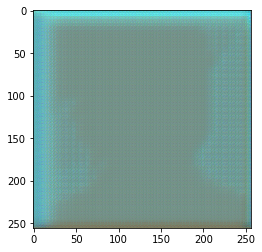

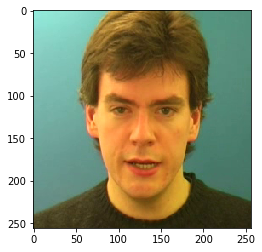

face loss:  0 MSE:  0.1054573580622673 latent loss:  0.042101409286260605 avg MSE:  0.16915321505855466 epoch:  0 image:  750


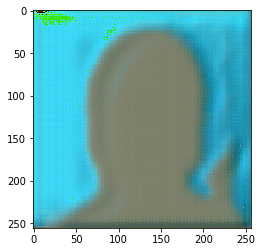

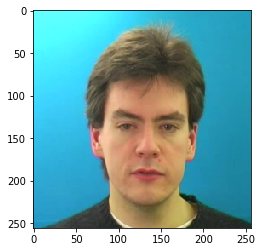

face loss:  0 MSE:  0.14281201362609863 latent loss:  0.05439045652747154 avg MSE:  0.16760628868578079 epoch:  0 image:  800


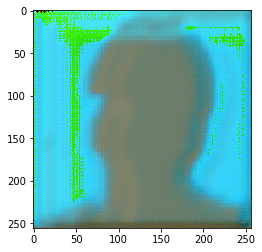

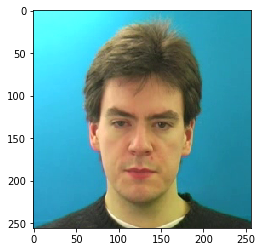

face loss:  0 MSE:  0.1243773102760315 latent loss:  0.010843843221664429 avg MSE:  0.16592778585036969 epoch:  0 image:  850


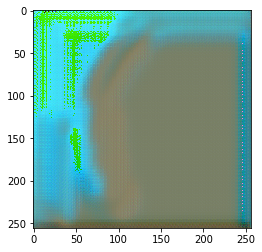

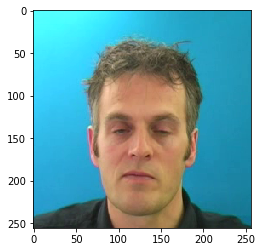

face loss:  0 MSE:  0.1571924388408661 latent loss:  0.010793445631861687 avg MSE:  0.16355111651726223 epoch:  0 image:  900


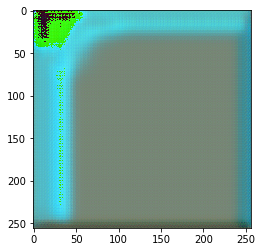

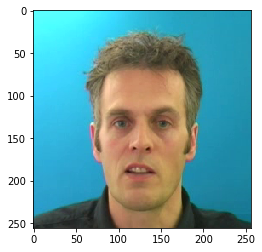

face loss:  0 MSE:  0.0876571387052536 latent loss:  0.016547916457057 avg MSE:  0.16113939513888142 epoch:  0 image:  950


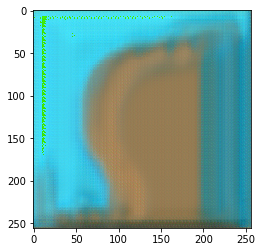

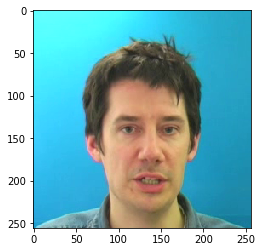

face loss:  0 MSE:  0.09957019984722137 latent loss:  0.6697748303413391 avg MSE:  0.15819259325077722 epoch:  0 image:  1000


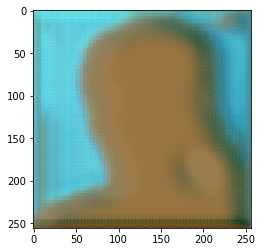

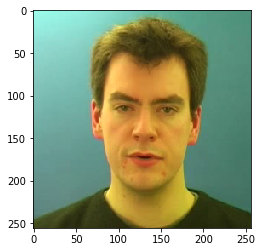

face loss:  0 MSE:  0.09911556541919708 latent loss:  0.35000601410865784 avg MSE:  0.15604387322967106 epoch:  0 image:  1050


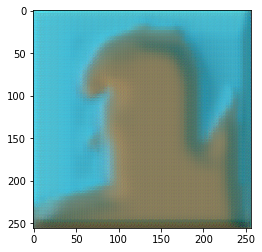

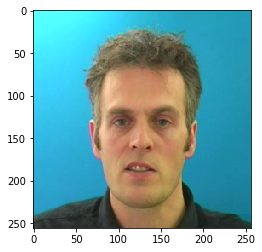

face loss:  0 MSE:  0.26029130816459656 latent loss:  0.09269224107265472 avg MSE:  0.1571912103883252 epoch:  0 image:  1100


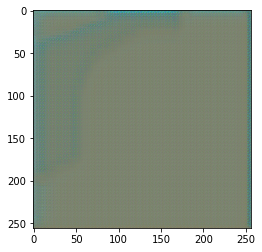

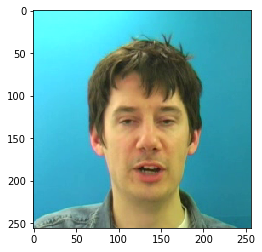

face loss:  0 MSE:  0.23324942588806152 latent loss:  0.029667051509022713 avg MSE:  0.1588321626380565 epoch:  0 image:  1150


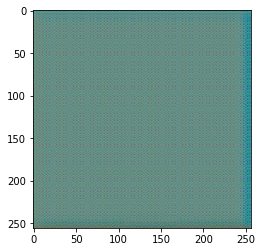

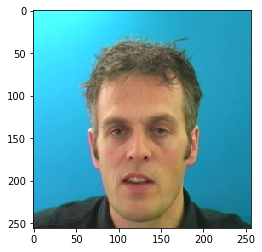

face loss:  0 MSE:  0.20692822337150574 latent loss:  0.00820532813668251 avg MSE:  0.16153500359396852 epoch:  0 image:  1200


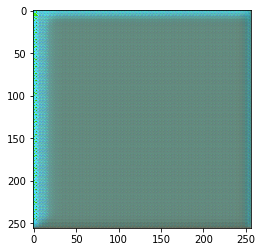

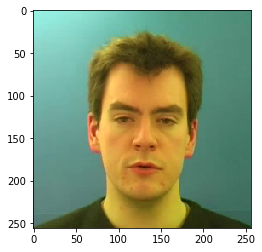

face loss:  0 MSE:  0.11887839436531067 latent loss:  0.020790105685591698 avg MSE:  0.16210518545693725 epoch:  0 image:  1250


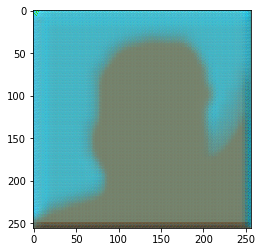

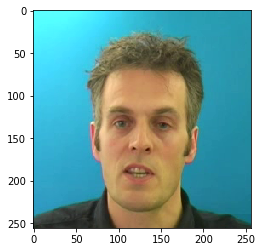

face loss:  0 MSE:  0.08368991315364838 latent loss:  0.009691874496638775 avg MSE:  0.1601543359567256 epoch:  0 image:  1300


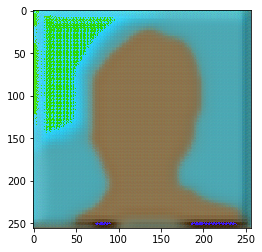

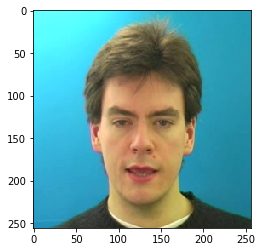

face loss:  0 MSE:  0.05234765633940697 latent loss:  0.02287975326180458 avg MSE:  0.1571616695947024 epoch:  0 image:  1350


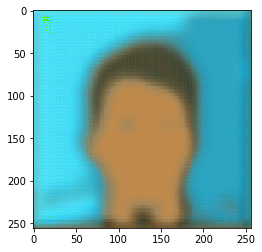

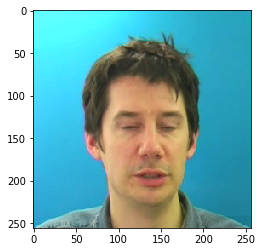

face loss:  0 MSE:  0.036566637456417084 latent loss:  0.0173224788159132 avg MSE:  0.153121527074321 epoch:  0 image:  1400


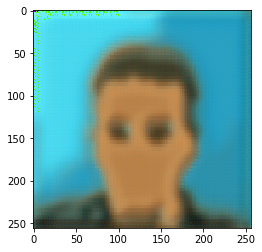

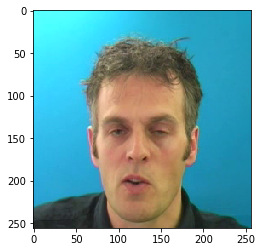

face loss:  0 MSE:  0.03216033801436424 latent loss:  0.00675671873614192 avg MSE:  0.14920116816843115 epoch:  0 image:  1450


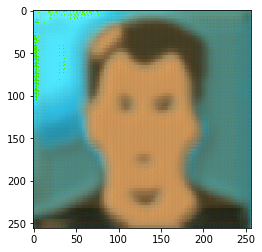

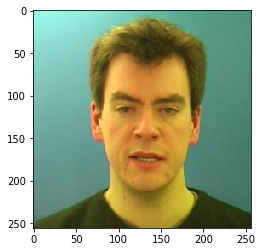

face loss:  0 MSE:  0.037358369678258896 latent loss:  0.022801503539085388 avg MSE:  0.14538366827793633 epoch:  0 image:  1500


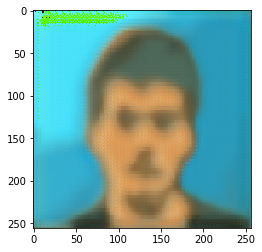

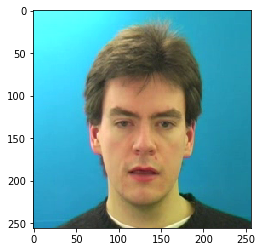

face loss:  0 MSE:  0.027327679097652435 latent loss:  0.006691435351967812 avg MSE:  0.14162994876052393 epoch:  0 image:  1550


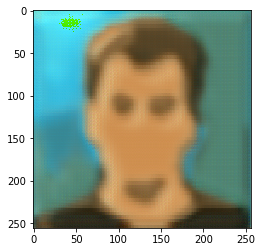

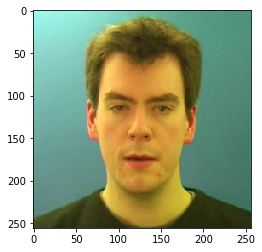

face loss:  0 MSE:  0.027435172349214554 latent loss:  0.011897999793291092 avg MSE:  0.1380215518893226 epoch:  0 image:  1600


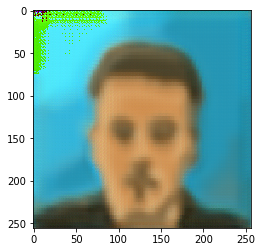

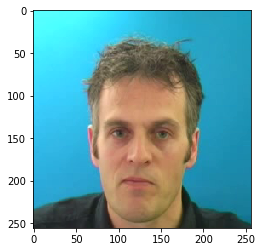

face loss:  0 MSE:  0.02338641695678234 latent loss:  0.01288848277181387 avg MSE:  0.13461210362179976 epoch:  0 image:  1650


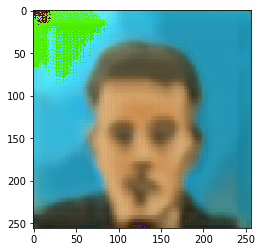

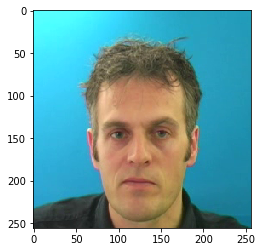

face loss:  0 MSE:  0.023517310619354248 latent loss:  0.009839155711233616 avg MSE:  0.13139600414500244 epoch:  0 image:  1700


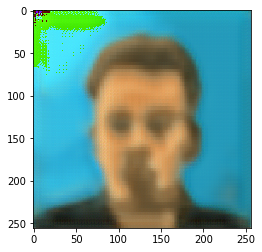

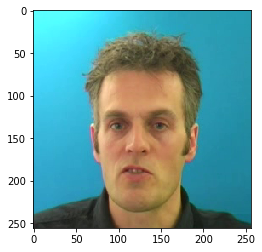

face loss:  0 MSE:  0.023913513869047165 latent loss:  0.01242015790194273 avg MSE:  0.1282648561636187 epoch:  0 image:  1750


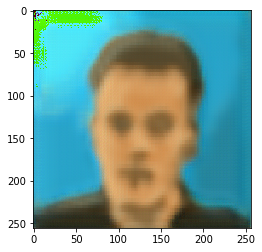

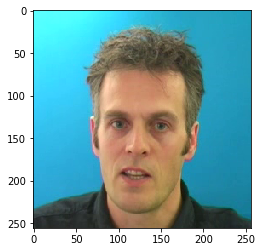

face loss:  0 MSE:  0.021784067153930664 latent loss:  0.010355952195823193 avg MSE:  0.12531064540098139 epoch:  0 image:  1800


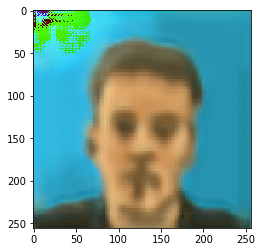

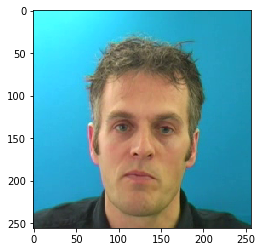

face loss:  0 MSE:  0.01826956868171692 latent loss:  0.010843487456440926 avg MSE:  0.12246422601540723 epoch:  0 image:  1850


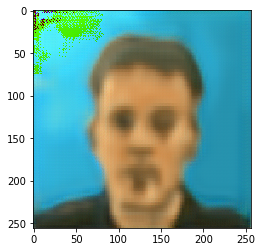

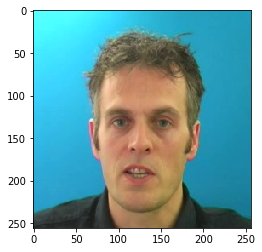

face loss:  0 MSE:  0.019068777561187744 latent loss:  0.010641226544976234 avg MSE:  0.11974039041034991 epoch:  0 image:  1900


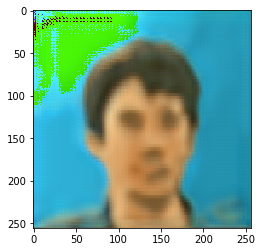

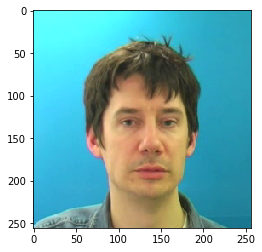

face loss:  0 MSE:  0.025285987183451653 latent loss:  0.009946279227733612 avg MSE:  0.11713645456722536 epoch:  0 image:  1950


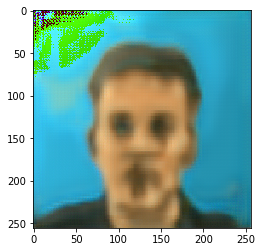

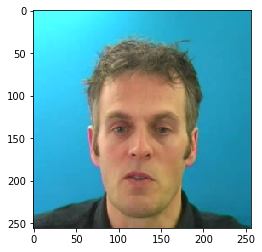

face loss:  0 MSE:  0.022924598306417465 latent loss:  0.00900979619473219 avg MSE:  0.11490945424139871 epoch:  0 image:  2000


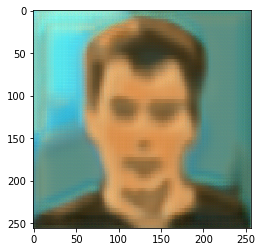

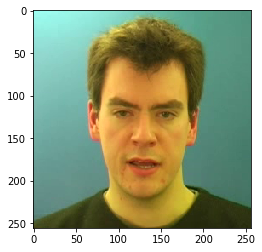

face loss:  0 MSE:  0.018032357096672058 latent loss:  0.008177714422345161 avg MSE:  0.11256598802042743 epoch:  0 image:  2050


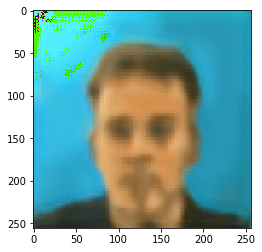

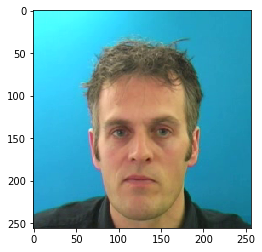

face loss:  0 MSE:  0.016868673264980316 latent loss:  0.008274557068943977 avg MSE:  0.11030658312152535 epoch:  0 image:  2100


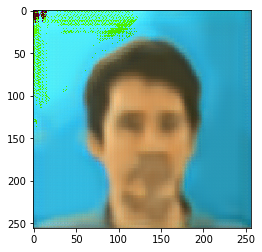

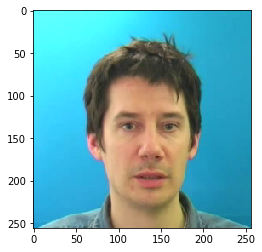

face loss:  0 MSE:  0.016228321939706802 latent loss:  0.009265613742172718 avg MSE:  0.10811585838019308 epoch:  0 image:  2150


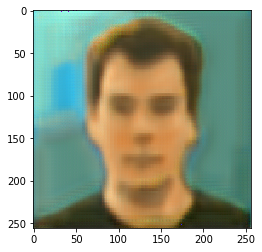

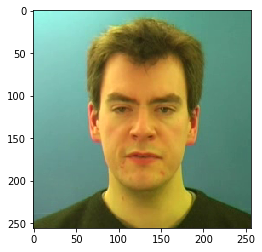

face loss:  0 MSE:  0.015573849901556969 latent loss:  0.008083688095211983 avg MSE:  0.10600695171575826 epoch:  0 image:  2200


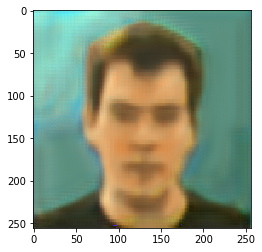

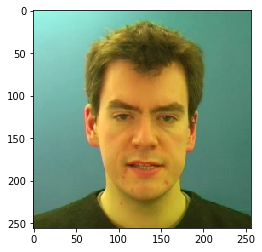

face loss:  0 MSE:  0.03315768018364906 latent loss:  0.008175678551197052 avg MSE:  0.10449160071547457 epoch:  0 image:  2250


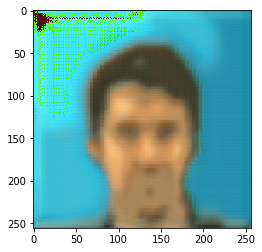

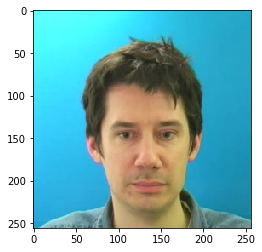

face loss:  0 MSE:  0.020505014806985855 latent loss:  0.00801124982535839 avg MSE:  0.10277953675370509 epoch:  0 image:  2300


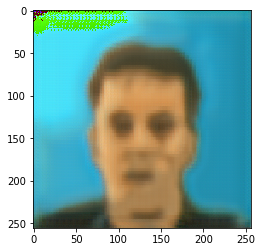

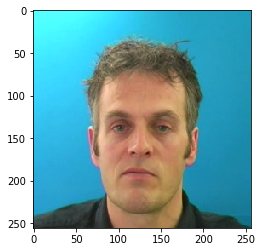

face loss:  0 MSE:  0.017474902793765068 latent loss:  0.014126606285572052 avg MSE:  0.10103228094744739 epoch:  0 image:  2350


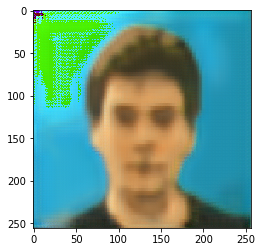

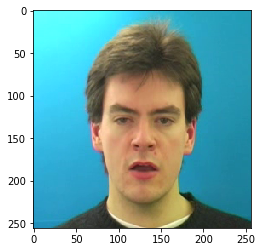

face loss:  0 MSE:  0.022924697026610374 latent loss:  0.009207808412611485 avg MSE:  0.09941133030413687 epoch:  0 image:  2400


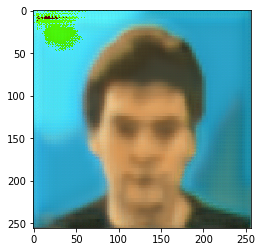

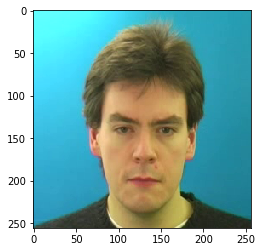

face loss:  0 MSE:  0.02296893298625946 latent loss:  0.009415416978299618 avg MSE:  0.09784011516958682 epoch:  0 image:  2450


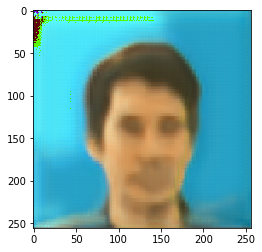

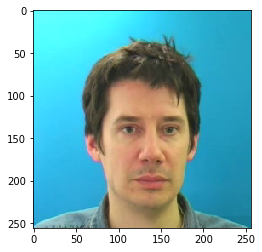

face loss:  0 MSE:  0.01780150830745697 latent loss:  0.008390454575419426 avg MSE:  0.09625151469299599 epoch:  0 image:  2500


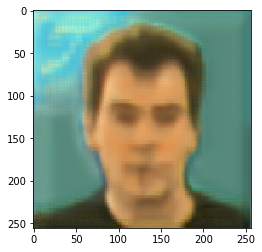

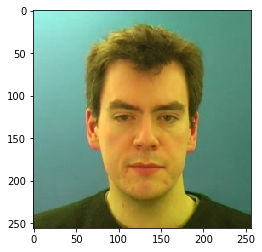

face loss:  0 MSE:  0.014454907737672329 latent loss:  0.009835481643676758 avg MSE:  0.09466724902039496 epoch:  0 image:  2550


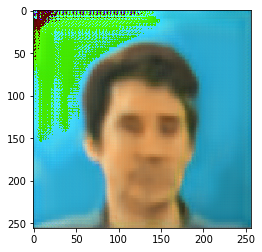

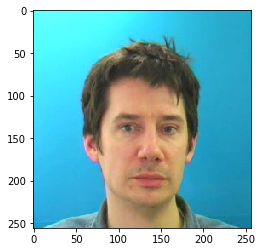

face loss:  0 MSE:  0.015016058459877968 latent loss:  0.010229517705738544 avg MSE:  0.09313096454340544 epoch:  0 image:  2600


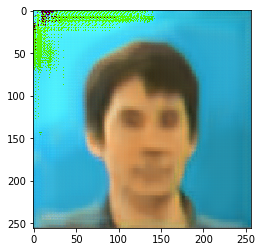

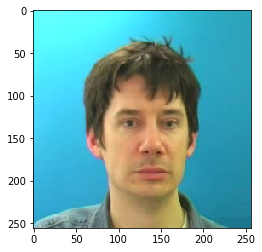

face loss:  0 MSE:  0.014508802443742752 latent loss:  0.010905224829912186 avg MSE:  0.0916444471928701 epoch:  0 image:  2650


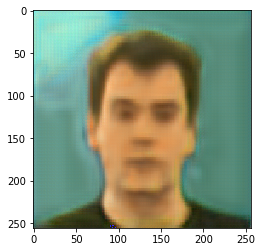

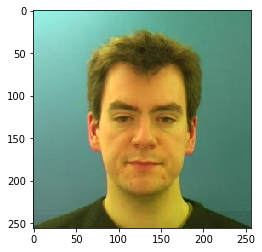

face loss:  0 MSE:  0.01304500363767147 latent loss:  0.010630267672240734 avg MSE:  0.09019795280523661 epoch:  0 image:  2700


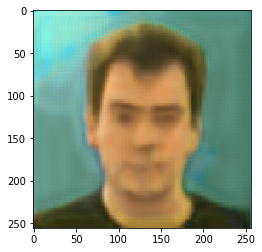

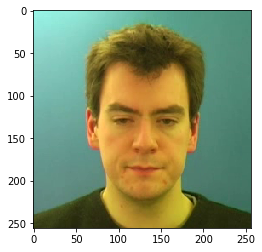

face loss:  0 MSE:  0.01264768373221159 latent loss:  0.010538002476096153 avg MSE:  0.08879145942066408 epoch:  0 image:  2750


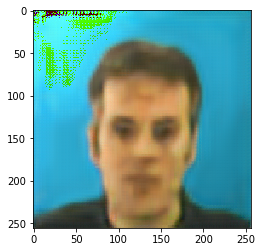

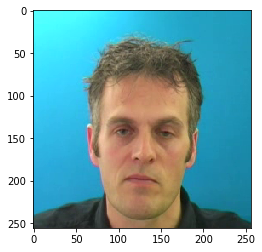

face loss:  0 MSE:  0.011737793684005737 latent loss:  0.009578046388924122 avg MSE:  0.08743158356685249 epoch:  0 image:  2800


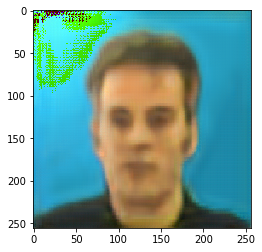

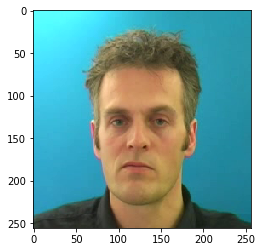

In [ ]:
for e in range(EPOCHS):

    mse_sum = 0
    mse_n = 0

    for i, batch in enumerate(dataloader):

        model.zero_grad()

#         if batch['image'].shape[0] != 128:
#             continue

        img = batch['image'].to(device)
#         aud = batch['audio'].view(128,1,10000).to(device)
        id_img = batch['id'].to(device)

        out, latent_loss = model(id_img)
        recon_loss = criterion(out, img)

    #     lower_face_loss = criterion2(out[:,:,:80,:], img[:,:,:80,:])

        lower_face_loss = 0

        latent_loss = latent_loss.mean()

        loss = recon_loss + latent_loss_weight * latent_loss
        loss.backward()

        if scheduler is not None:
            scheduler.step()

        optimizer.step()

        mse_sum += recon_loss.item() * img.shape[0]
        mse_n += img.shape[0]

        lr = optimizer.param_groups[0]['lr']

        if i % 50 == 0 and i != 0:
            print("face loss: ", lower_face_loss, "MSE: ", recon_loss.item(), 
                  "latent loss: ", latent_loss.item(), "avg MSE: ", mse_sum / mse_n, "epoch: ", e, "image: ", i)
            test_img = (np.moveaxis(out.cpu().detach().numpy(),1,-1) + 1) / 2.0 * 255
            inp_img = (np.moveaxis(img.cpu().detach().numpy(),1,-1) + 1) / 2.0 * 255
            plt.imshow(test_img[40].astype(np.uint8))
            plt.show()
            plt.imshow(inp_img[40].astype(np.uint8))
            plt.show()

    torch.save(model.state_dict(), './model_dir/GAG_256_RES_16' + str(e))

    #     loader.set_description(
    #         (
    #             f'epoch: {epoch + 1}; mse: {recon_loss.item():.5f}; '
    #             f'latent: {latent_loss.item():.3f}; avg mse: {mse_sum / mse_n:.5f}; '
    #             f'lr: {lr:.5f}'
    #         )
    #     )

    #     if i % 100 == 0:
    #         model.eval()

    #         sample = img[:sample_size]

    #         with torch.no_grad():
    #             out, _ = model(sample)

    #         utils.save_image(
    #             torch.cat([sample, out], 0),
    #             f'sample/{str(epoch + 1).zfill(5)}_{str(i).zfill(5)}.png',
    #             nrow=sample_size,
    #             normalize=True,
    #             range=(-1, 1),
    #         )

    #         model.train()

# Create Animation

In [11]:
# grab the names of the pre-processed video files
video_names = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

# delete bad entries
bad_files = ['bgit2n', 'lbij7a', 'lrbr3s', 'pbio7a', 'sbaa4p', 'sgwp8p', 'sbim8p', 
             'srwi5a', 'swao7a', 'srbb4n', 'sbbbzp', 'lrae3s']

for i,f in enumerate(video_names):
    
    for bad in bad_files:
        if f.find(bad) != -1:
            del video_names[i]
            break

In [12]:
class getDataSample():
    def __init__(self, gpu=1):

        self.audio_path = '/home/jarrod/dev/speech-driven-animation/data/npy_audio/'
        self.device = torch.device("cuda:" + str(gpu))

        self.mean_face = np.load('/home/jarrod/dev/speech-driven-animation/data/mean_face.npy')
        self.img_size = (128,128)
        self.aux_latent = 10
        self.sequential_noise = True
    
        rnn_gen_dim = 256
        id_enc_dim = 128
        aud_enc_dim = 256
        audio_feat_len = 0.2
        self.audio_rate = 50000
        self.video_rate = 25
        self.audio_feat_samples = 10000
        self.conversion_dict = {'s16': np.int16, 's32': np.int32}
        
        # image preprocessing
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    def preprocess_img(self, img):
        src = self.fa.get_landmarks(img)[0][self.stablePntsIDs, :]
        dst = self.mean_face[self.stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src, dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=self.img_size)  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

        return warped

    def __call__(self, filename, num_d1_samples, fs=None, aligned=False):
        
        audio_filename = self.audio_path + filename.split('/')[-1].split('.npy')[0] + '.wav.npy'
        
       
    
        vid_data = np.load(filename)
        frame = np.copy(vid_data[0])
                
        # take the input image and preprocess it    
        frame = self.img_transform(frame)
            
        frame = frame.unsqueeze(0)
        
        # Load preprocessed audio data
        audio_feat_seq = np.load(audio_filename)
        
        audio_feat_seq = torch.Tensor(audio_feat_seq)
        audio_feat_seq_length = audio_feat_seq.shape[1]
                
        samp = np.random.rand(num_d1_samples)*audio_feat_seq_length
        samp = samp.astype(int)

        
        normed_vid_data = []
        
        for i, img in enumerate(vid_data):
            normed_vid_data.append((self.img_transform(img)+ 1.0) / 2.0)
        
        normed_vid_data = torch.stack(normed_vid_data)
        
#         d1_frames = normed_vid_data[samp]

        # shuffle the id frames, otherwise the discriminator learns too fast    
#         np.random.shuffle(samp)
#         d1_frames_shuff = normed_vid_data[samp]

#         frame_c = frame.repeat(num_d1_samples,1,1,1) 
        # concat the id_frame onto the back of axis 1 (indices 3:)
#         d1_frames = torch.cat((d1_frames, d1_frames_shuff), axis=1)
        
        
        return audio_feat_seq, audio_feat_seq_length, frame, normed_vid_data

In [14]:
va = getDataSample()
aud, _, _, vid  = va(video_names[0], 10, aligned=True)

In [ ]:
model.eval()

In [ ]:
img = batch['image'].to(device)
aud = batch['audio'].view(128,1,10000).to(device)
id_img = batch['id'].to(device)


out, latent_loss = model(id_img, aud)

In [20]:
vid = vid.to(device)

In [22]:
aud = aud.view(75,1,10000)

In [29]:
pad = torch.zeros(53,3,128,128).to(device)

In [ ]:
new_aud = torch.cat((aud, pad),0) 

In [31]:
new_vid = torch.cat((vid, pad),0) 

In [33]:
new_aud = new_aud.to(device)

In [62]:
video_names[0]

'/home/jarrod/dev/speech-driven-animation/data/aligned_faces/sgii4a.npy'

In [36]:
out, latent_loss = model(new_vid, new_aud)

In [43]:
output = out.permute(0,2,3,1).cpu().detach().numpy()

In [39]:
import skvideo.io as sio
import ffmpeg

In [60]:
def save_video(video, overwrite=True, experimental_ffmpeg=False, scale=None):
      
      
        
        # Save the video file
        writer = sio.FFmpegWriter("/home/jarrod/dev/vq-vae-2-pytorch/tmp.avi",
                                  inputdict={'-r': str(24) + "/1", },
                                  outputdict={'-r': str(24) + "/1", }
                                  )
        for i in range(video.shape[0]):
#             frame = np.rollaxis(video[i, :, :, :], 0, 3)

#             if scale is not None:
#                 frame = tf.rescale(frame, scale, anti_aliasing=True, multichannel=True, mode='reflect')

            writer.writeFrame(video[i])
        writer.close()

In [61]:
save_video(output)

In [42]:
out.shape

torch.Size([128, 3, 128, 128])

In [51]:
output = np.clip(output,0,1.0)

In [54]:
output = output * 255

In [55]:
output = output.astype(np.uint8)

In [59]:
output.shape

(128, 128, 128, 3)

# Debug

In [ ]:
inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
plt.imshow(inp_img[60])
plt.show()

In [47]:
for i, batch in enumerate(dataloader):
    
    model.zero_grad()

    if batch['image'].shape[0] != 128:
        continue
    
    img = batch['image'].to(device)
    aud = batch['audio'].view(128,1,10000).to(device)
    id_img = batch['id'].to(device)
    
    
    out, latent_loss = model(img, aud)
    break

In [44]:
out = out[20].permute(1,2,0).cpu().detach().numpy()
target = batch['image'][20].permute(1,2,0).cpu().detach().numpy()
diff = np.sqrt(np.square(out - target))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


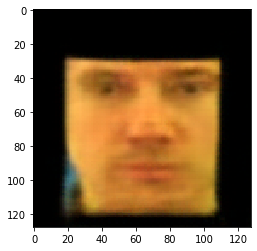

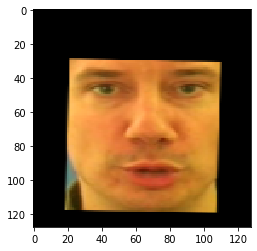

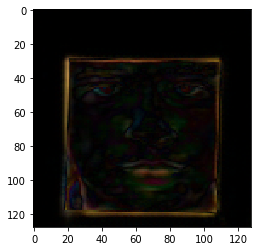

In [45]:
plt.imshow(out)
plt.show()
plt.imshow(target)
plt.show()
plt.imshow(diff)
plt.show()

In [34]:
np.max(diff)

0.5083602

In [46]:
out.shape

(128, 128, 3)

In [49]:
out[:,:,:10,:10] = 1